In [1]:
import pandas as pd
import numpy as np
import tensorflow
import keras

import plotly.graph_objects as go
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.utils import class_weight

# Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('/content/drive/My Drive/DL_FinalProject/data/X_train.npy')
y_train = np.load('/content/drive/My Drive/DL_FinalProject/data/y_train.npy')

In [3]:
y_valid = np.load('/content/drive/My Drive/DL_FinalProject/data/y_valid.npy')

# Visualization

In [ ]:
class_counts = np.sum(y_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 159  (3.04%)
Class 1: 229  (4.38%)
Class 2: 509  (9.73%)
Class 3: 51   (0.98%)
Class 4: 3782 (72.33%)
Class 5: 430  (8.22%)
Class 6: 69   (1.32%)


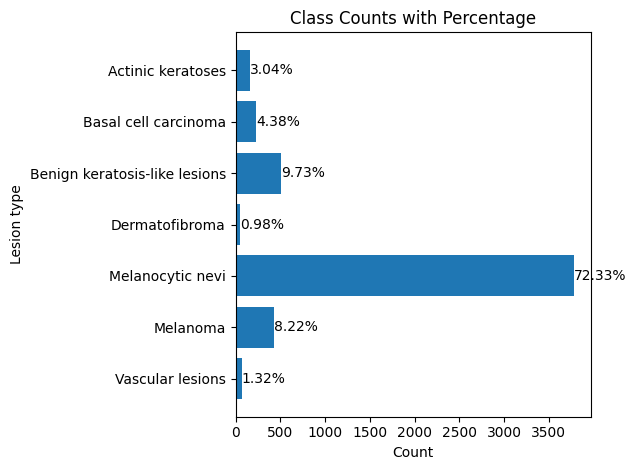

In [ ]:
class_counts = np.sum(y_train, axis=0)
percentages = [(count / sum(class_counts)) * 100 for count in class_counts]

class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

# Plotting the horizontal bar chart
fig, ax = plt.subplots()
bars = ax.barh(range(len(class_counts)), class_counts)

# Adding the percentage labels on the right side of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{percentages[i]:.2f}%', va='center')

# Adding class names as tick labels
ax.set_yticks(range(len(class_counts)))
ax.set_yticklabels([class_names[i] for i in range(len(class_counts))])

# Adding labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Lesion type')
ax.set_title('Class Counts with Percentage')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

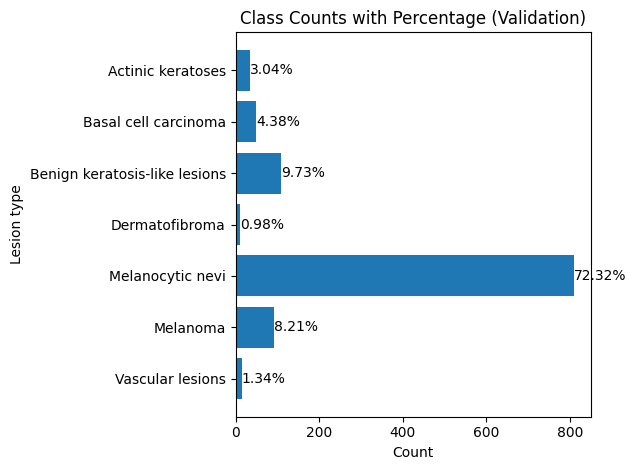

In [4]:
class_counts = np.sum(y_valid, axis=0)
percentages = [(count / sum(class_counts)) * 100 for count in class_counts]

class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

# Plotting the horizontal bar chart
fig, ax = plt.subplots()
bars = ax.barh(range(len(class_counts)), class_counts)

# Adding the percentage labels on the right side of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{percentages[i]:.2f}%', va='center')

# Adding class names as tick labels
ax.set_yticks(range(len(class_counts)))
ax.set_yticklabels([class_names[i] for i in range(len(class_counts))])

# Adding labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Lesion type')
ax.set_title('Class Counts with Percentage (Validation)')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

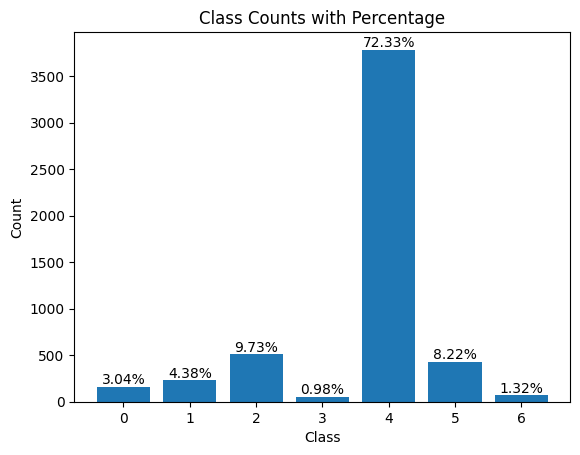

In [ ]:
class_counts = np.sum(y_train, axis=0)
percentages = [(count / sum(class_counts)) * 100 for count in class_counts]

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(range(len(class_counts)), class_counts)

# Adding the percentage labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentages[i]:.2f}%', ha='center', va='bottom')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Counts with Percentage')
plt.show()

# Training data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
def balance_classes(X_train, y_train, datagen, target_samples=4000):
    class_totals = np.sum(y_train, axis=0)
    class_indices = [np.where(np.argmax(y_train, axis=1) == class_index)[0] for class_index in range(y_train.shape[1])]

    X_balanced = []
    y_balanced = []

    # Downsample majority class
    for i, indices in enumerate(class_indices):
        if len(indices) > target_samples:
            np.random.seed(42)
            selected_indices = np.random.choice(indices, target_samples, replace=False)
            X_balanced.extend(X_train[selected_indices])
            y_balanced.extend(y_train[selected_indices])
        else:
            X_balanced.extend(X_train[indices])
            y_balanced.extend(y_train[indices])

    # Augment minority classes
    for i, indices in enumerate(class_indices):
        n_samples_needed = target_samples - len(indices)
        if n_samples_needed <= 0:
            continue

        new_X, new_y = [], []
        while n_samples_needed > 0:
            selected_index = np.random.choice(indices)
            x_new = datagen.random_transform(X_train[selected_index])
            y_new = y_train[selected_index]

            new_X.append(x_new)
            new_y.append(y_new)

            n_samples_needed -= 1

        X_balanced.extend(new_X)
        y_balanced.extend(new_y)

    X_balanced = np.array(X_balanced)
    y_balanced = np.array(y_balanced)

    return X_balanced, y_balanced


## 4000 images per class

In [ ]:
X_balanced_4000_train, y_balanced_4000_train = balance_classes(X_train, y_train,
                                                              datagen,
                                                              target_samples=4000)

In [ ]:
X_train.shape, X_balanced_4000_train.shape

((5229, 75, 100, 3), (28000, 75, 100, 3))

In [ ]:
class_counts = np.sum(y_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 159  (3.04%)
Class 1: 229  (4.38%)
Class 2: 509  (9.73%)
Class 3: 51   (0.98%)
Class 4: 3782 (72.33%)
Class 5: 430  (8.22%)
Class 6: 69   (1.32%)


In [ ]:
class_counts = np.sum(y_balanced_4000_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 4000 (14.29%)
Class 1: 4000 (14.29%)
Class 2: 4000 (14.29%)
Class 3: 4000 (14.29%)
Class 4: 4000 (14.29%)
Class 5: 4000 (14.29%)
Class 6: 4000 (14.29%)


In [ ]:
X_balanced_4000_list = np.array(list(X_balanced_4000_train))

In [ ]:
np.save('/content/drive/My Drive/DL_FinalProject/data/X_balanced_4000_train.npy', X_balanced_4000_list)
np.save('/content/drive/My Drive/DL_FinalProject/data/y_balanced_4000_train.npy', y_balanced_4000_train)

## 6000 images per class

In [ ]:
X_balanced_6000_train, y_balanced_6000_train = balance_classes(X_train, y_train,
                                                   datagen,
                                                   target_samples=6000)

In [ ]:
X_train.shape, X_balanced_6000_train.shape

((5229, 75, 100, 3), (42000, 75, 100, 3))

In [ ]:
class_counts = np.sum(y_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 159  (3.04%)
Class 1: 229  (4.38%)
Class 2: 509  (9.73%)
Class 3: 51   (0.98%)
Class 4: 3782 (72.33%)
Class 5: 430  (8.22%)
Class 6: 69   (1.32%)


In [ ]:
class_counts = np.sum(y_balanced_6000_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 6000 (14.29%)
Class 1: 6000 (14.29%)
Class 2: 6000 (14.29%)
Class 3: 6000 (14.29%)
Class 4: 6000 (14.29%)
Class 5: 6000 (14.29%)
Class 6: 6000 (14.29%)


In [ ]:
X_balanced_6000_list = np.array(list(X_balanced_6000_train))

In [ ]:
np.save('/content/drive/My Drive/DL_FinalProject/data/X_balanced_6000_train.npy', X_balanced_6000_train)
np.save('/content/drive/My Drive/DL_FinalProject/data/y_balanced_6000_train.npy', y_balanced_6000_train)


data to be loaded like:

In [ ]:
X_balanced_4000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/X_balanced_4000_train.npy')
y_balanced_4000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/y_balanced_4000_train.npy')

In [ ]:
X_balanced_4000_train.shape, y_balanced_4000_train.shape

((28000, 75, 100, 3), (28000, 7))

In [ ]:
X_balanced_6000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/X_balanced_6000_train.npy')
y_balanced_6000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/y_balanced_6000_train.npy')

In [ ]:
X_balanced_6000_train.shape, y_balanced_6000_train.shape

((42000, 75, 100, 3), (42000, 7))

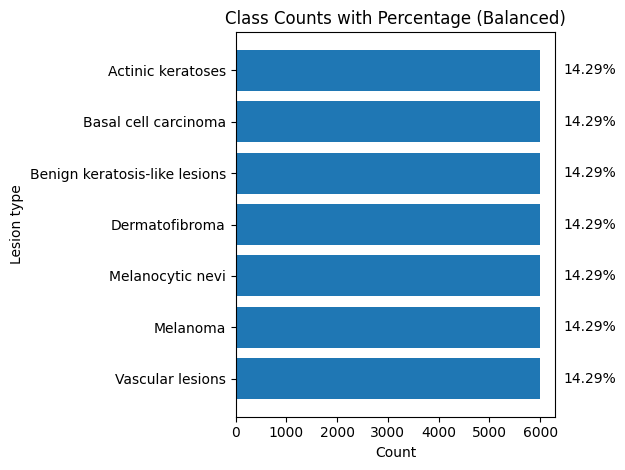

In [ ]:
class_counts = np.sum(y_balanced_6000_train, axis=0)
percentages = [(count / sum(class_counts)) * 100 for count in class_counts]

class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

# Plotting the horizontal bar chart
fig, ax = plt.subplots()
bars = ax.barh(range(len(class_counts)), class_counts)

# Adding the percentage labels on the right side of each bar
for i, bar in enumerate(bars):
    width = bar.get_width() + 450
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{percentages[i]:.2f}%', va='center')

# Adding class names as tick labels
ax.set_yticks(range(len(class_counts)))
ax.set_yticklabels([class_names[i] for i in range(len(class_counts))])

# Adding labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Lesion type')
ax.set_title('Class Counts with Percentage (Balanced)')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Augmented data visualization
trying different ways

In [ ]:
def show_original_and_augmented(X_train, y_train, datagen, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))

    sample_indices = np.random.choice(np.arange(len(X_train)), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Original image
        original_image = X_train[idx]
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original - Class {np.argmax(y_train[idx])}")
        axes[i, 0].axis('off')

        # Augmented image
        augmented_image = datagen.random_transform(original_image)
        axes[i, 1].imshow(augmented_image)
        axes[i, 1].set_title(f"Augmented - Class {np.argmax(y_train[idx])}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

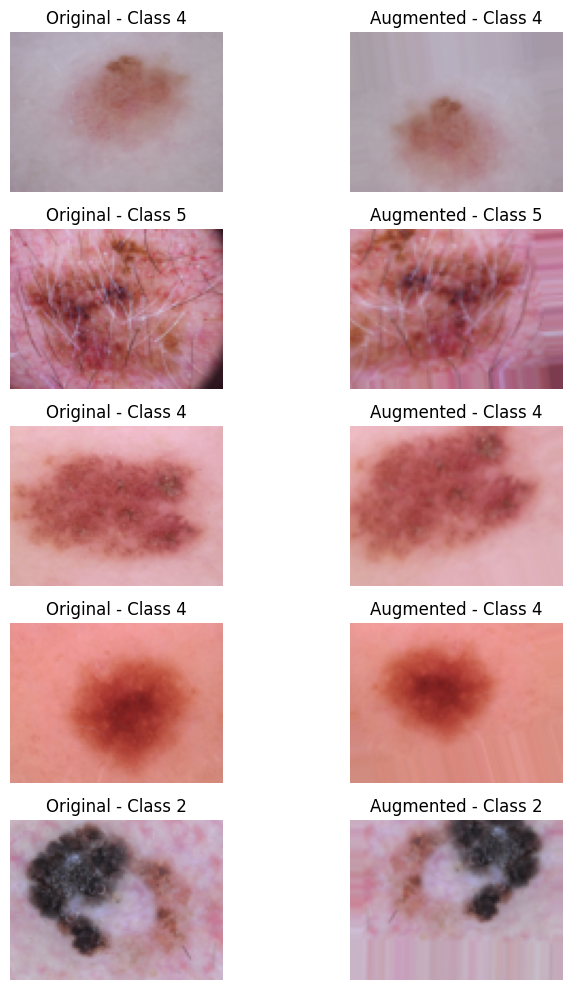

In [ ]:
show_original_and_augmented(X_train, y_train, datagen, num_samples=5)

In [ ]:
def show_original_and_augmented_by_class(X_train, y_train, datagen, num_samples=5):
    class_indices = np.argmax(y_train, axis=1)

    num_classes = y_train.shape[1]

    fig, axes = plt.subplots(num_classes, num_samples * 2, figsize=(2 * num_samples * 2, 2 * num_classes))

    for class_id in range(num_classes):
        indices_of_class = np.where(class_indices == class_id)[0]
        num_samples_class = min(len(indices_of_class), num_samples)

        selected_indices = np.random.choice(indices_of_class, num_samples_class, replace=False)

        for i, idx in enumerate(selected_indices):

            original_image = X_train[idx]
            ax_orig = axes[class_id, i * 2]
            ax_orig.imshow(original_image)
            ax_orig.set_title(f"Original - Class {class_id}")
            ax_orig.axis('off')

            augmented_image = datagen.random_transform(original_image)
            ax_aug = axes[class_id, i * 2 + 1]
            ax_aug.imshow(augmented_image)
            ax_aug.set_title(f"Augmented - Class {class_id}")
            ax_aug.axis('off')

    plt.tight_layout()
    plt.show()

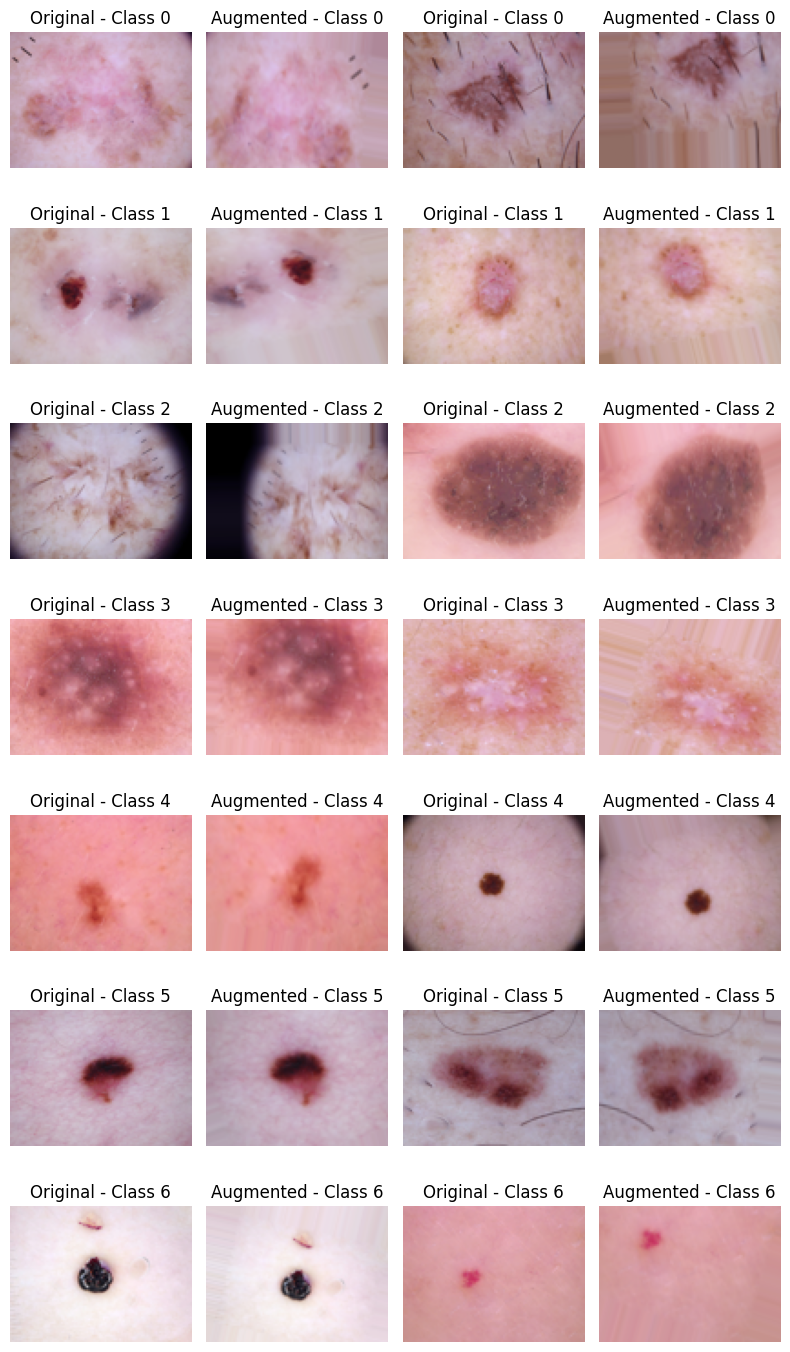

In [ ]:
show_original_and_augmented_by_class(X_train, y_train, datagen, num_samples=2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_original_and_augmented_by_class(X_train, y_train, datagen, class_names, num_samples=5):
    class_indices = np.argmax(y_train, axis=1)

    num_classes = y_train.shape[1]

    fig, axes = plt.subplots(num_classes, num_samples * 2, figsize=(2 * num_samples * 2, 2 * num_classes))

    for class_id in range(num_classes):
        indices_of_class = np.where(class_indices == class_id)[0]
        num_samples_class = min(len(indices_of_class), num_samples)

        selected_indices = np.random.choice(indices_of_class, num_samples_class, replace=False)

        for i, idx in enumerate(selected_indices):

            original_image = X_train[idx]
            ax_orig = axes[class_id, i * 2]
            ax_orig.imshow(original_image)
            ax_orig.set_title(f"Original - {class_names[class_id]}", fontsize=8)  # Decrease text size
            ax_orig.axis('off')

            augmented_image = datagen.random_transform(original_image)
            ax_aug = axes[class_id, i * 2 + 1]
            ax_aug.imshow(augmented_image)
            ax_aug.set_title(f"Augmented - {class_names[class_id]}", fontsize=8)  # Decrease text size
            ax_aug.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

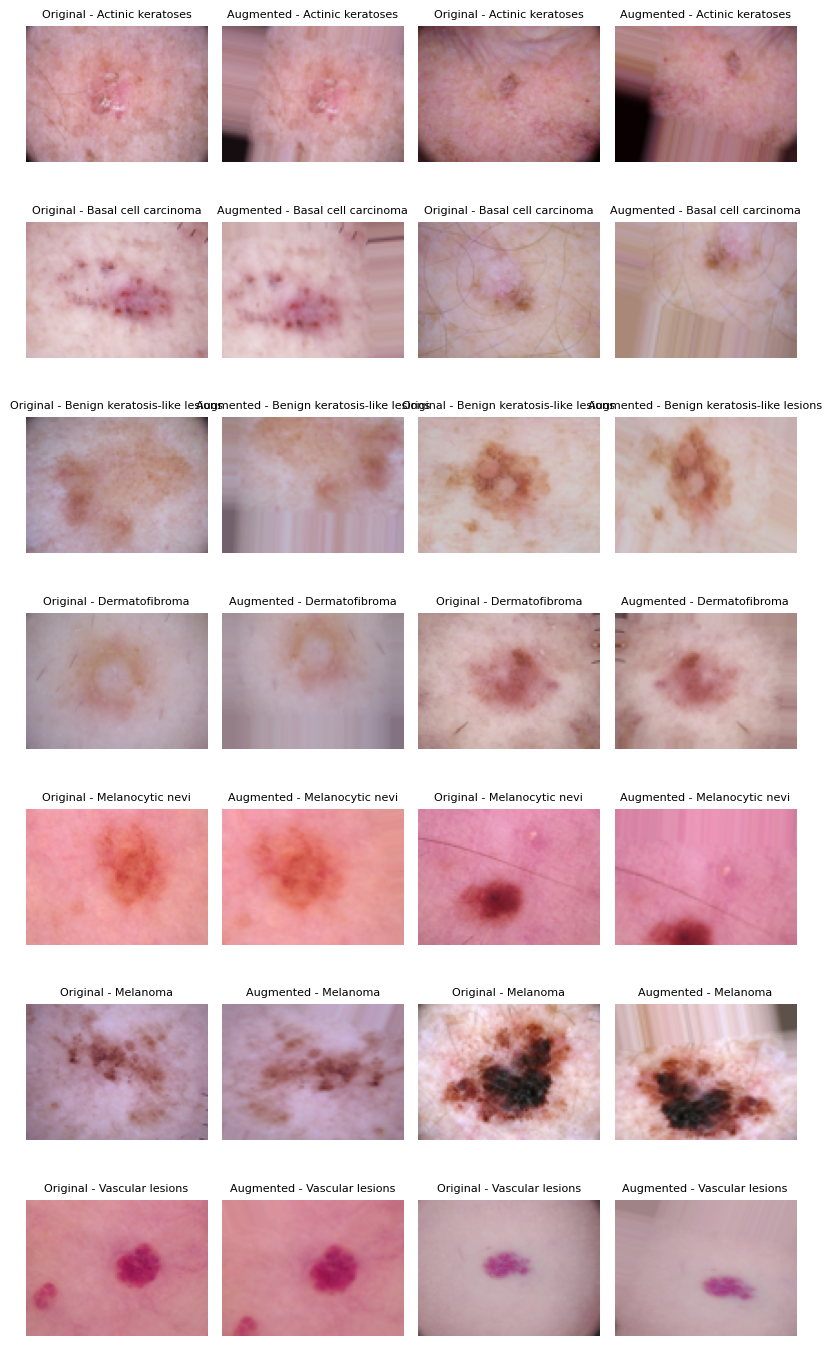

In [ ]:
show_original_and_augmented_by_class(X_train, y_train, datagen, class_names, num_samples=2)

In [ ]:
def show_one_original_and_five_augmented(X_train, y_train, datagen):
    class_indices = np.argmax(y_train, axis=1)
    num_classes = y_train.shape[1]

    fig, axes = plt.subplots(num_classes, 6, figsize=(15, 2 * num_classes))

    for class_id in range(num_classes):
        indices_of_class = np.where(class_indices == class_id)[0]

        original_idx = np.random.choice(indices_of_class)
        original_image = X_train[original_idx]

        axes[class_id, 0].imshow(original_image)
        axes[class_id, 0].set_title(f"Original - Class {class_id}")
        axes[class_id, 0].axis('off')

        for i in range(5):
            augmented_image = datagen.random_transform(original_image)
            axes[class_id, i + 1].imshow(augmented_image)
            axes[class_id, i + 1].set_title(f"Augmented {i+1}")
            axes[class_id, i + 1].axis('off')

    plt.tight_layout()
    plt.show()

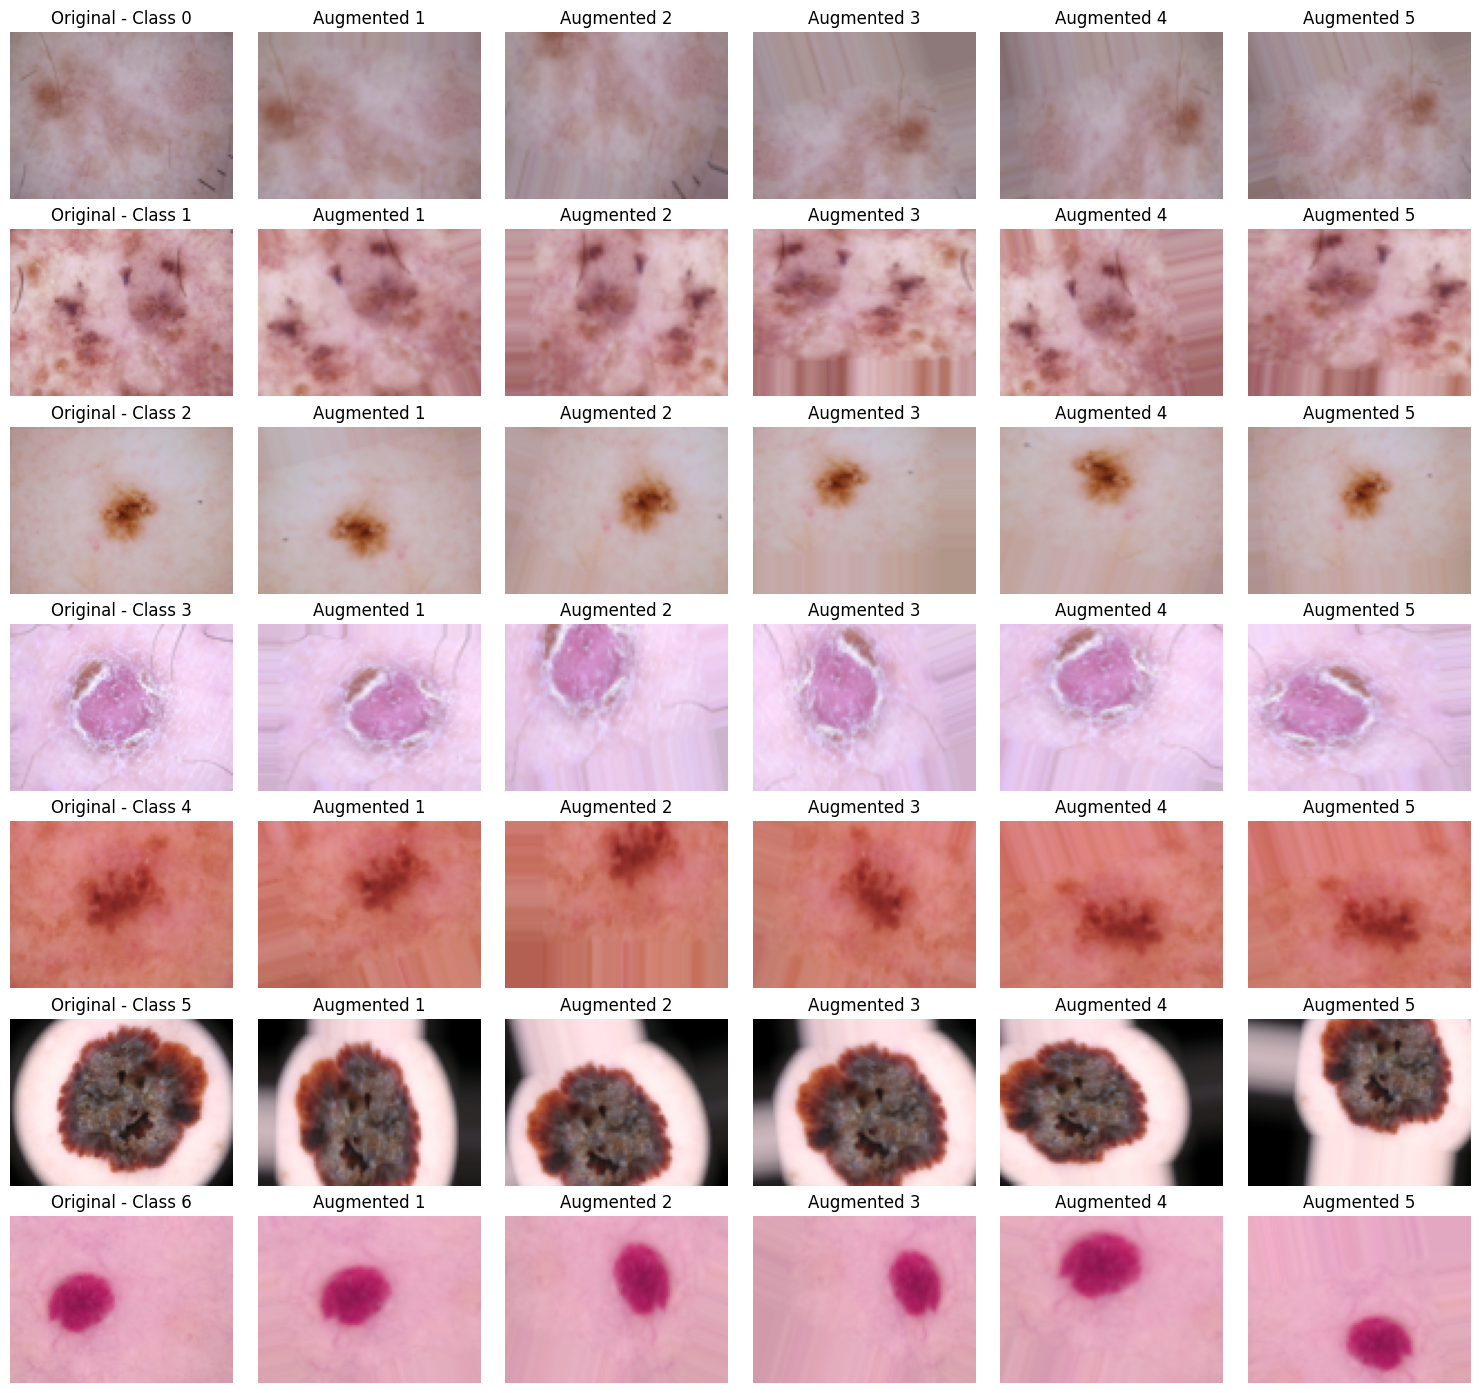

In [ ]:
show_one_original_and_five_augmented(X_train, y_train, datagen)

In [ ]:
def show_one_original_and_five_augmented_1(X_train, y_train, datagen):
    idx = np.random.randint(0, len(X_train))
    original_image = X_train[idx]
    class_id = np.argmax(y_train[idx])

    fig, axes = plt.subplots(1, 6, figsize=(15, 3))

    axes[0].imshow(original_image)
    axes[0].set_title(f"Original - Class {class_id}")
    axes[0].axis('off')

    for i in range(1, 6):
        augmented_image = datagen.random_transform(original_image)
        axes[i].imshow(augmented_image)
        axes[i].set_title(f"Augmented {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

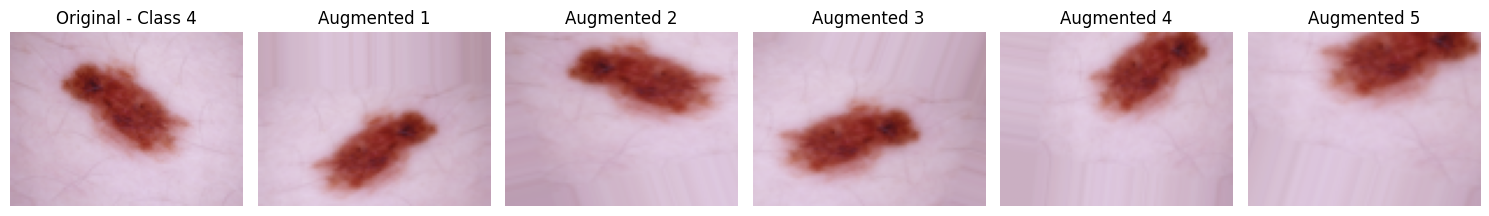

In [ ]:
show_one_original_and_five_augmented_1(X_train, y_train, datagen)